In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import tensorflow as tf

C:\Users\shadowleaf\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def view_image(img, figsize=(16, 16), cmap='inferno'):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.show()

In [54]:
def view_mammogram(LCC, LMLO, RCC, RMLO, figsize=(16, 16), cmap='inferno'):
    plt.figure(figsize=figsize)

    plt.subplots_adjust(hspace=0.001, wspace=0.001)
    
    plt.subplot(2, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(RCC, cmap=cmap)
    plt.subplot(2, 2, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(LCC, cmap=cmap)
    plt.subplot(2, 2, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(RMLO, cmap=cmap)
    plt.subplot(2, 2, 4)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(LMLO, cmap=cmap)

    plt.tight_layout()
    
    plt.show()

In [55]:
LCC = pydicom.dcmread("./CBIS-DDSM/Calc-Training_P_00008_LEFT_CC/08-07-2016-DDSM-64189/1-full mammogram images-20834/000000.dcm")
LMLO = pydicom.dcmread("./CBIS-DDSM/Calc-Training_P_00008_LEFT_MLO/08-07-2016-DDSM-28663/1-full mammogram images-97907/000000.dcm")
RCC = pydicom.dcmread("./CBIS-DDSM/Calc-Training_P_00008_RIGHT_CC/08-07-2016-DDSM-64555/1-full mammogram images-28729/000000.dcm")
RMLO = pydicom.dcmread("./CBIS-DDSM/Calc-Training_P_00008_RIGHT_MLO/08-07-2016-DDSM-21704/1-full mammogram images-32980/000000.dcm")

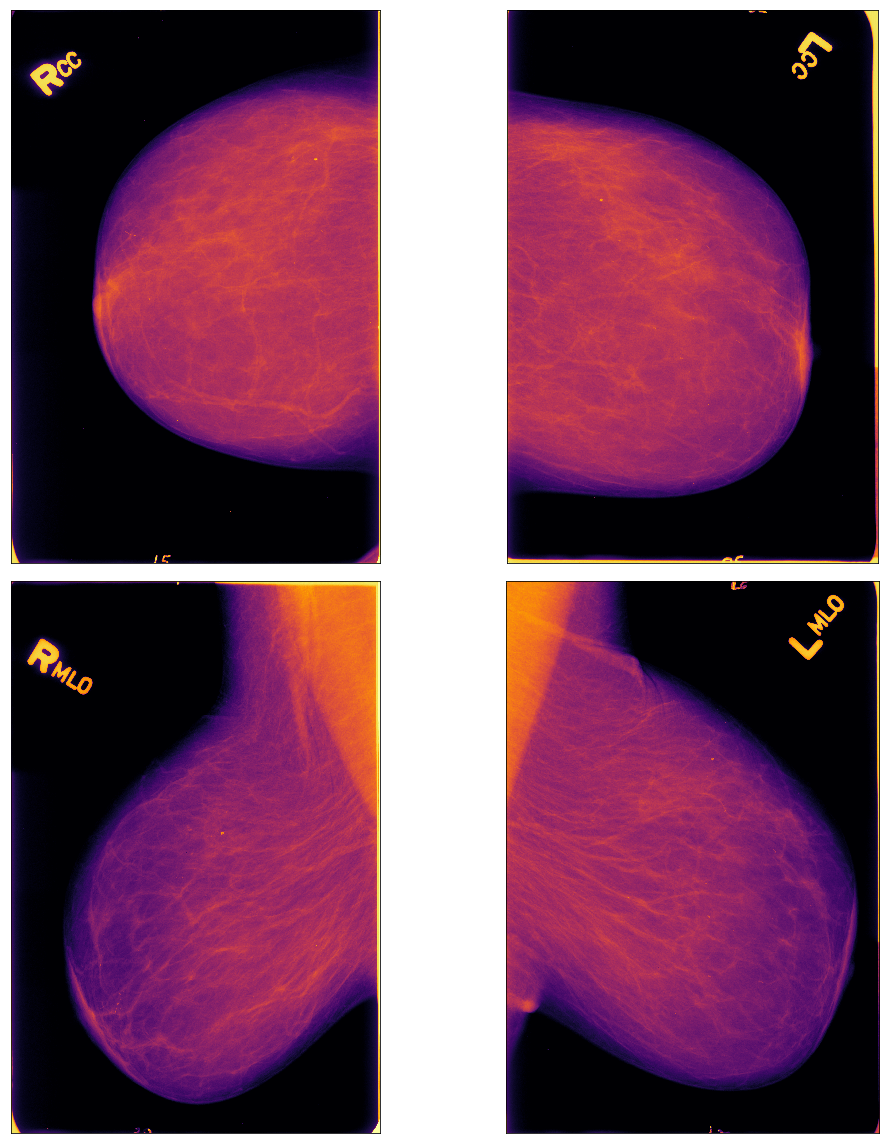

In [56]:
view_mammogram(LCC.pixel_array, LMLO.pixel_array, RCC.pixel_array, RMLO.pixel_array)

In [57]:
lcc_img = LCC.pixel_array.astype(np.float32)
lmlo_img = LMLO.pixel_array.astype(np.float32)
rcc_img = RCC.pixel_array.astype(np.float32)
rmlo_img = RMLO.pixel_array.astype(np.float32)

In [7]:
def normalize_image(img):
    img -= np.mean(img)
    img /= np.std(img)
    return img

In [58]:
normalize_image(cc_img)
normalize_image(mlo_img)
normalize_image(rcc_img)
normalize_image(rmlo_img)

array([[2.936433 , 2.9510498, 2.9568965, ..., 3.2736814, 3.2736814,
        3.2736814],
       [2.9481266, 2.9495883, 2.9466648, ..., 3.2736814, 3.2736814,
        3.2736814],
       [2.9539733, 2.9539733, 2.9466648, ..., 3.2736814, 3.2736814,
        3.2736814],
       ...,
       [2.9715133, 2.9700515, 2.9612815, ..., 3.2736814, 3.2736814,
        3.2736814],
       [2.96859  , 2.9671283, 2.964205 , ..., 3.2736814, 3.2736814,
        3.2736814],
       [2.9715133, 2.964205 , 2.96859  , ..., 3.2736814, 3.2736814,
        3.2736814]], dtype=float32)

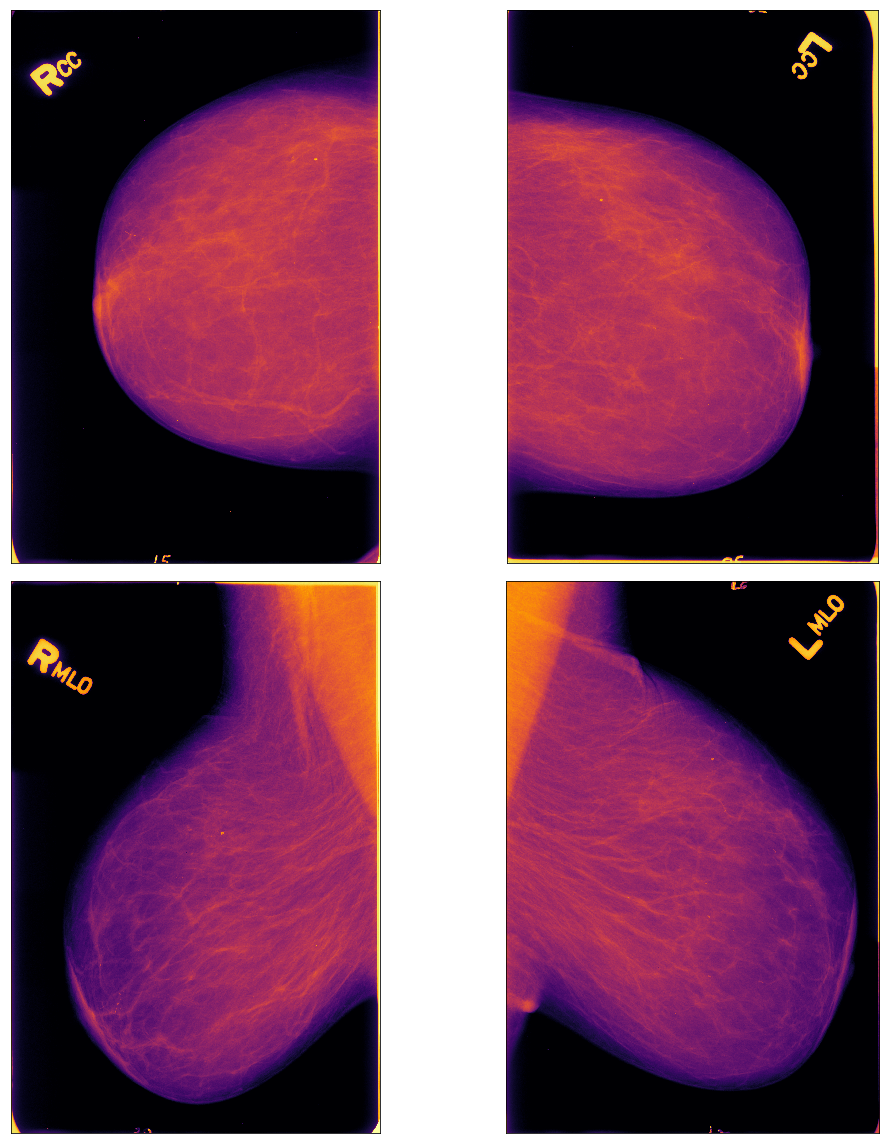

In [59]:
view_mammogram(lcc_img, lmlo_img, rcc_img, rmlo_img)

# Layers

In [60]:
def all_views_conv_layer(input_layer, layer_name, number_of_filters=32, filter_size=(3, 3), stride=(1, 1),
                         padding='VALID', biases_initializer=tf.zeros_initializer()):
    """Convolutional layers across all 4 views"""
  
    input_l_cc, input_r_cc, input_l_mlo, input_r_mlo = input_layer

    with tf.variable_scope(layer_name + "_CC") as cc_cope:
        h_l_cc = tf.contrib.layers.convolution2d(inputs=input_l_cc, num_outputs=number_of_filters,
                                                 kernel_size=filter_size, stride=stride, padding=padding,
                                                 scope=cc_cope, biases_initializer=biases_initializer)
        h_r_cc = tf.contrib.layers.convolution2d(inputs=input_r_cc, num_outputs=number_of_filters,
                                                 kernel_size=filter_size, stride=stride, padding=padding, reuse=True,
                                                 scope=cc_cope, biases_initializer=biases_initializer)

    with tf.variable_scope(layer_name + "_MLO") as mlo_cope:
        h_l_mlo = tf.contrib.layers.convolution2d(inputs=input_l_mlo, num_outputs=number_of_filters,
                                                  kernel_size=filter_size, stride=stride, padding=padding,
                                                  scope=mlo_cope, biases_initializer=biases_initializer)
        h_r_mlo = tf.contrib.layers.convolution2d(inputs=input_r_mlo, num_outputs=number_of_filters,
                                                  kernel_size=filter_size, stride=stride, padding=padding, reuse=True,
                                                  scope=mlo_cope, biases_initializer=biases_initializer)

    h = (h_l_cc, h_r_cc, h_l_mlo, h_r_mlo)

    return h


def all_views_max_pool(input_layer, stride=(2, 2)):
    """Max-pool across all 4 views"""
  
    input_l_cc, input_r_cc, input_l_mlo, input_r_mlo = input_layer

    output_l_cc = tf.nn.max_pool(input_l_cc, ksize=[1, stride[0], stride[1], 1], strides=[1, stride[0], stride[1], 1],
                                 padding='SAME')
    output_r_cc = tf.nn.max_pool(input_r_cc, ksize=[1, stride[0], stride[1], 1], strides=[1, stride[0], stride[1], 1],
                                 padding='SAME')
    output_l_mlo = tf.nn.max_pool(input_l_mlo, ksize=[1, stride[0], stride[1], 1], strides=[1, stride[0], stride[1], 1],
                                  padding='SAME')
    output_r_mlo = tf.nn.max_pool(input_r_mlo, ksize=[1, stride[0], stride[1], 1], strides=[1, stride[0], stride[1], 1],
                                  padding='SAME')

    output = (output_l_cc, output_r_cc, output_l_mlo, output_r_mlo)

    return output


def all_views_global_avg_pool(input_layer):
    """Average-pool across all 4 views"""
  
    input_l_cc, input_r_cc, input_l_mlo, input_r_mlo = input_layer

    input_layer_shape = input_l_cc.get_shape()
    pooling_shape = [1, input_layer_shape[1], input_layer_shape[2], 1]

    output_l_cc = tf.nn.avg_pool(input_l_cc, ksize=pooling_shape, strides=pooling_shape, padding='SAME')
    output_r_cc = tf.nn.avg_pool(input_r_cc, ksize=pooling_shape, strides=pooling_shape, padding='SAME')
    output_l_mlo = tf.nn.avg_pool(input_l_mlo, ksize=pooling_shape, strides=pooling_shape, padding='SAME')
    output_r_mlo = tf.nn.avg_pool(input_r_mlo, ksize=pooling_shape, strides=pooling_shape, padding='SAME')

    output = (output_l_cc, output_r_cc, output_l_mlo, output_r_mlo)

    return output


def all_views_flattening_layer(input_layer):
    """Flatten and concatenate all activations from all 4 views"""
  
    input_l_cc, input_r_cc, input_l_mlo, input_r_mlo = input_layer

    input_layer_shape = input_l_cc.get_shape()
    input_layer_size = int(input_layer_shape[1]) * int(input_layer_shape[2]) * int(input_layer_shape[3])

    h_l_cc_flat = tf.reshape(input_l_cc, [-1, input_layer_size])
    h_r_cc_flat = tf.reshape(input_r_cc, [-1, input_layer_size])
    h_l_mlo_flat = tf.reshape(input_l_mlo, [-1, input_layer_size])
    h_r_mlo_flat = tf.reshape(input_r_mlo, [-1, input_layer_size])

    h_flat = tf.concat(axis=1, values=[h_l_cc_flat, h_r_cc_flat, h_l_mlo_flat, h_r_mlo_flat])

    return h_flat


def fc_layer(input_layer, number_of_units=128, activation_fn=tf.nn.relu, reuse=None, scope=None):
    """Fully connected layer"""

    h = tf.contrib.layers.fully_connected(inputs=input_layer, num_outputs=number_of_units, activation_fn=activation_fn,
                                          reuse=reuse, scope=scope)

    return h


def softmax_layer(input_layer, number_of_outputs=3):
    """Softmax layer"""
  
    with tf.variable_scope('fully_connected_1') as fully_scope:
        y_prediction = tf.contrib.layers.fully_connected(inputs=input_layer, num_outputs=number_of_outputs,
                                                         activation_fn=tf.nn.softmax, scope=fully_scope)
        
    return y_prediction


def dropout_layer(input_layer, nodropout_probability):
    """Dropout layer"""
  
    output = tf.nn.dropout(input_layer, nodropout_probability)

    return output


def gaussian_noise_layer(input_layer, std):
    """Additive gaussian noise layer"""
  
    noise = tf.random_normal(tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32)

    output = tf.add_n([input_layer, noise])

    return output


def all_views_gaussian_noise_layer(input_layer, std):
    """Add gaussian noise across all 4 views"""
  
    input_l_cc, input_r_cc, input_l_mlo, input_r_mlo = input_layer

    output_l_cc = gaussian_noise_layer(input_l_cc, std)
    output_r_cc = gaussian_noise_layer(input_r_cc, std)
    output_l_mlo = gaussian_noise_layer(input_l_mlo, std)
    output_r_mlo = gaussian_noise_layer(input_r_mlo, std)

    output = (output_l_cc, output_r_cc, output_l_mlo, output_r_mlo)
    
    return output

# Model

In [61]:
def baseline(x, parameters, nodropout_probability=None, gaussian_noise_std=None):

    if gaussian_noise_std is not None:
        x = all_views_gaussian_noise_layer(x, gaussian_noise_std)

    # first conv sequence
    h = all_views_conv_layer(x, 'conv1', number_of_filters=32, filter_size=[3, 3], stride=[2, 2])

    # second conv sequence
    h = all_views_max_pool(h, stride=[3, 3])
    h = all_views_conv_layer(h, 'conv2a', number_of_filters=64, filter_size=[3, 3], stride=[2, 2])
    h = all_views_conv_layer(h, 'conv2b', number_of_filters=64, filter_size=[3, 3], stride=[1, 1])
    h = all_views_conv_layer(h, 'conv2c', number_of_filters=64, filter_size=[3, 3], stride=[1, 1])

    # third conv sequence
    h = all_views_max_pool(h, stride=[2, 2])
    h = all_views_conv_layer(h, 'conv3a', number_of_filters=128, filter_size=[3, 3], stride=[1, 1])
    h = all_views_conv_layer(h, 'conv3b', number_of_filters=128, filter_size=[3, 3], stride=[1, 1])
    h = all_views_conv_layer(h, 'conv3c', number_of_filters=128, filter_size=[3, 3], stride=[1, 1])

    # fourth conv sequence
    h = all_views_max_pool(h, stride=[2, 2])
    h = all_views_conv_layer(h, 'conv4a', number_of_filters=128, filter_size=[3, 3], stride=[1, 1])
    h = all_views_conv_layer(h, 'conv4b', number_of_filters=128, filter_size=[3, 3], stride=[1, 1])
    h = all_views_conv_layer(h, 'conv4c', number_of_filters=128, filter_size=[3, 3], stride=[1, 1])

    # fifth conv sequence
    h = all_views_max_pool(h, stride=[2, 2])
    h = all_views_conv_layer(h, 'conv5a', number_of_filters=256, filter_size=[3, 3], stride=[1, 1])
    h = all_views_conv_layer(h, 'conv5b', number_of_filters=256, filter_size=[3, 3], stride=[1, 1])
    h = all_views_conv_layer(h, 'conv5c', number_of_filters=256, filter_size=[3, 3], stride=[1, 1])

    # Pool, flatten, and fully connected layers
    h = all_views_global_avg_pool(h)
    h = all_views_flattening_layer(h)
    h = fc_layer(h, number_of_units=1024)
    h = dropout_layer(h, nodropout_probability)

    y_prediction_birads = softmax_layer(h, number_of_outputs=3)

    return y_prediction_birads


class BaselineBreastModel:

    def __init__(self, parameters, x, nodropout_probability=None, gaussian_noise_std=None):
        self.y_prediction_birads = baseline(x, parameters, nodropout_probability, gaussian_noise_std)

In [62]:
import numpy as np
import imageio


def load_images(image_path, view):
    """
    Function that loads and preprocess input images
    :param image_path: base path to image
    :param view: L-CC / R-CC / L-MLO / R-MLO
    :return: Batch x Height x Width x Channels array
    """
    image = imageio.imread(image_path + view + '.png')
    image = image.astype(np.float32)
    normalize_single_image(image)
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=3)

    return image


def normalize_single_image(image):
    """
    Normalize image in-place
    :param image: numpy array
    """
    image -= np.mean(image)
    image /= np.std(image)

In [63]:
def inference(parameters, verbose=True):
    """
    Function that creates a model, loads the parameters, and makes a prediction
    :param parameters: dictionary of parameters
    :param verbose: Whether to print predicted probabilities
    :return: Predicted probabilities for each class 
    """
    tf.set_random_seed(7)

    with tf.Graph().as_default():
        with tf.device('/' + parameters['device_type']):
            # initialize input holders
            x_l_cc = tf.placeholder(tf.float32,
                                    shape=[None, parameters['input_size'][0], parameters['input_size'][1], 1])
            x_r_cc = tf.placeholder(tf.float32,
                                    shape=[None, parameters['input_size'][0], parameters['input_size'][1], 1])
            x_l_mlo = tf.placeholder(tf.float32,
                                     shape=[None, parameters['input_size'][0], parameters['input_size'][1], 1])
            x_r_mlo = tf.placeholder(tf.float32,
                                     shape=[None, parameters['input_size'][0], parameters['input_size'][1], 1])
            x = (x_l_cc, x_r_cc, x_l_mlo, x_r_mlo)

            # holders for dropout and Gaussian noise
            nodropout_probability = tf.placeholder(tf.float32, shape=())
            gaussian_noise_std = tf.placeholder(tf.float32, shape=())

            # construct models
            model = BaselineBreastModel(parameters, x, nodropout_probability, gaussian_noise_std)
            y_prediction_birads = model.y_prediction_birads

        # allocate computation resources
        if parameters['device_type'] == 'gpu':
            session_config = tf.ConfigProto()
            session_config.gpu_options.visible_device_list = str(parameters['gpu_number'])
        elif parameters['device_type'] == 'cpu':
            session_config = tf.ConfigProto(device_count={'GPU': 0})
        else:
            raise RuntimeError(parameters['device_type'])

        with tf.Session(config=session_config) as session:
            session.run(tf.global_variables_initializer())

            # loads the pre-trained parameters if it's provided
            saver = tf.train.Saver(max_to_keep=None)
            saver.restore(session, save_path=parameters['model_path'])

            # load input images
#             datum_l_cc = load_images(parameters['image_path'], 'L-CC')
#             datum_r_cc = load_images(parameters['image_path'], 'R-CC')
#             datum_l_mlo = load_images(parameters['image_path'], 'L-MLO')
#             datum_r_mlo = load_images(parameters['image_path'], 'R-MLO')
            datum_l_cc = lcc_img
            datum_r_cc = rcc_img
            datum_l_mlo = lmlo_img
            datum_r_mlo = rmlo_img

            # populate feed_dict for TF session
            # No dropout and no gaussian noise in inference
            feed_dict_by_model = {
                nodropout_probability: 1.0,
                gaussian_noise_std: 0.0,
                x_l_cc: datum_l_cc,
                x_r_cc: datum_r_cc,
                x_l_mlo: datum_l_mlo,
                x_r_mlo: datum_r_mlo,
            }

            # run the session for a prediction
            prediction_birads = session.run(y_prediction_birads, feed_dict=feed_dict_by_model)

            if verbose:
                # nicely prints out the predictions
                birads0_prob = prediction_birads[0][0]
                birads1_prob = prediction_birads[0][1]
                birads2_prob = prediction_birads[0][2]
                print('BI-RADS prediction:\n' +
                      '\tBI-RADS 0:\t' + str(birads0_prob) + '\n' +
                      '\tBI-RADS 1:\t' + str(birads1_prob) + '\n' +
                      '\tBI-RADS 2:\t' + str(birads2_prob))

            return prediction_birads[0]


def run():

#     parser = argparse.ArgumentParser(description='Run Inference')
#     parser.add_argument('--model-path', default='saved_models/model.ckpt')
#     parser.add_argument('--device-type', default="cpu")
#     parser.add_argument('--gpu-number', default=0, type=int)
#     parser.add_argument('--image-path', default="images/")
#     args = parser.parse_args()

    parameters_ = {
        "model_path": 'saved_models/model.ckpt',
        "device_type": "cpu",
        "gpu_number": 0,
        "image_path": "images/",
        "input_size": (2600, 2000),
    }

    # do a sample prediction
    inference(parameters_)

In [64]:
run()

INFO:tensorflow:Restoring parameters from saved_models/model.ckpt


ValueError: Cannot feed value of shape (4568, 3064) for Tensor 'Placeholder:0', which has shape '(?, 2600, 2000, 1)'